In [294]:
import torch
import scipy.io as sio
from scipy.spatial.distance import cdist
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

In [295]:
with open("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/produced/labels.pkl", "rb") as f:
    labels_and_names = pickle.load(f)

In [296]:
labels = labels_and_names['labels']
label_names = labels_and_names['labelNames']

In [297]:
unique_labels, counts = np.unique(labels, return_counts=True)

In [298]:
unique_names, counts = np.unique(label_names, return_counts=True)

In [299]:
sorted_indices = np.argsort(counts)[::-1]

In [300]:
top_classes = unique_labels[sorted_indices][:10]

In [301]:
top_counts = counts[sorted_indices][:10]

In [302]:
top_class_indices = {cls: np.where(labels == cls)[0] for cls in top_classes}

In [303]:
with open("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/produced/sentence_embeddings.pkl", "rb") as f:
    sentence_embeddings = pickle.load(f)

In [304]:
embeddings_agg = sentence_embeddings["st_embeddings_agg"]
embeddings_avg = sentence_embeddings["st_embeddings_avg"]

In [305]:
np.info(embeddings_agg)

class:  ndarray
shape:  (11788, 384)
strides:  (1536, 4)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x308118020
byteorder:  little
byteswap:  False
type: float32


In [306]:
class_attributes_agg = None
for label in unique_labels:
    class_indices = np.where(labels == label)[0]
    class_attribute = embeddings_agg[class_indices].mean(axis=0)
    if class_attributes_agg is None:
        class_attributes_agg = class_attribute
    else:
        class_attributes_agg = np.vstack((class_attributes_agg, class_attribute))

In [307]:
class_attributes_avg = None
for label in unique_labels:
    class_indices = np.where(labels == label)[0]
    class_attribute = embeddings_avg[class_indices].mean(axis=0)
    if class_attributes_avg is None:
        class_attributes_avg = class_attribute
    else:
        class_attributes_avg = np.vstack((class_attributes_avg, class_attribute))

In [308]:
new_class_attributes = {"class_attributes_avg": class_attributes_avg, "class_attributes_agg": class_attributes_agg}

In [309]:
with open("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/produced/class_attributes.pkl", "rb") as f:
    class_attributes = pickle.load(f)

In [310]:
# VISUALIZE RES101 FEATURES WITH T-SNE

In [311]:
with open("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/produced/res101_features.pkl", "rb") as f:
    res101_features = pickle.load(f)

In [312]:
pca = PCA(n_components=50, random_state=537)
res101_pca_features = pca.fit_transform(res101_features)

In [313]:
tsne = TSNE(n_components=2, random_state=537)
res101_tsne_features = tsne.fit_transform(res101_features)

In [314]:
def findClosestAndFurthestClasses(unique_labels, labels, res101_tsne_features, label_names):
    average_tsne_features = {}
    for cls in unique_labels:
        cls_indices = np.where(labels == cls)[0]
        average_tsne_features[cls] = res101_tsne_features[cls_indices].mean(axis=0)
        
    cls_list = list(average_tsne_features.keys())
    average_feature_matrix = np.array([average_tsne_features[cls] for cls in cls_list])
    
    pairwise_distances = cdist(average_feature_matrix, average_feature_matrix, metric='euclidean')
    
    furthest_pair_indices = np.unravel_index(np.argmax(pairwise_distances), pairwise_distances.shape)
    furthest_classes = (cls_list[furthest_pair_indices[0]], cls_list[furthest_pair_indices[1]])
    
    np.fill_diagonal(pairwise_distances, np.inf)
    
    closest_pair_indices = np.unravel_index(np.argmin(pairwise_distances), pairwise_distances.shape)
    closest_classes = (cls_list[closest_pair_indices[0]], cls_list[closest_pair_indices[1]])
    
    closest_class_names = (label_names[np.where(labels == closest_classes[0])[0][0]][0][0], label_names[np.where(labels == closest_classes[1])[0][0]][0][0])
    furthest_class_names = (label_names[np.where(labels == furthest_classes[0])[0][0]][0][0], label_names[np.where(labels == furthest_classes[1])[0][0]][0][0])
    
    print("Closest classes: ", closest_classes)
    print("Furthest classes: ", furthest_classes)
    print()
    print("Closest classes: ", closest_class_names)
    print("Furthest classes: ", furthest_class_names)
    
    return closest_class_names, furthest_class_names

In [315]:
pairs = findClosestAndFurthestClasses(unique_labels, labels, res101_tsne_features, label_names)

Closest classes:  (np.uint8(79), np.uint8(183))
Furthest classes:  (np.uint8(123), np.uint8(168))

Closest classes:  (np.str_('111.Loggerhead_Shrike'), np.str_('112.Great_Grey_Shrike'))
Furthest classes:  (np.str_('167.Hooded_Warbler'), np.str_('051.Horned_Grebe'))


In [ ]:
plt.figure(figsize=(10, 8))
for cls in top_classes:
    indices = top_class_indices[cls]
    cls_name = label_names[indices][0][0][0]
    plt.scatter(res101_tsne_features[indices, 0], res101_tsne_features[indices, 1], label=cls_name, s=10, alpha=1)

plt.title("t-SNE Plot of Resnet Image Features")
plt.legend()
plt.savefig("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/figures/res101_tsne.svg", format="svg", dpi=300)
plt.show()

In [ ]:
# VISUALIZE RES101 FEATURES WITH UMAP

In [ ]:
umap = UMAP(n_components=2, random_state=537)
res101_umap_features = umap.fit_transform(res101_features)

In [ ]:
plt.figure(figsize=(10, 8))
for cls in top_classes:
    indices = top_class_indices[cls]
    cls_name = label_names[indices][0][0][0]
    plt.scatter(res101_umap_features[indices, 0], res101_umap_features[indices, 1], label=cls_name, s=10, alpha=1)

plt.title("UMAP Plot of Resnet Image Features")
plt.legend()
plt.savefig("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/figures/res101_umap.svg", format="svg", dpi=300)
plt.show()

In [ ]:
# VISUALIZE CONVNEXT FEATURES WITH T-SNE

In [316]:
with open("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/produced/convnext_features.pkl", "rb") as f:
    convnext_features = pickle.load(f)

In [317]:
pca = PCA(n_components=50, random_state=537)
convnext_pca_features = pca.fit_transform(convnext_features)

In [318]:
tsne = TSNE(n_components=2, random_state=537)
convnext_tsne_features = tsne.fit_transform(convnext_features)

In [319]:
pairs = findClosestAndFurthestClasses(unique_labels, labels, convnext_tsne_features, label_names)

Closest classes:  (np.uint8(102), np.uint8(107))
Furthest classes:  (np.uint8(32), np.uint8(62))

Closest classes:  (np.str_('141.Artic_Tern'), np.str_('146.Forsters_Tern'))
Furthest classes:  (np.str_('048.European_Goldfinch'), np.str_('087.Mallard'))


In [ ]:
plt.figure(figsize=(10, 8))
for cls in top_classes:
    indices = top_class_indices[cls]
    cls_name = label_names[indices][0][0][0]
    plt.scatter(convnext_tsne_features[indices, 0], convnext_tsne_features[indices, 1], label=cls_name, s=10, alpha=1)

plt.title("t-SNE Plot of ConvNeXt Image Features")
plt.legend()
plt.savefig("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/figures/convnext_tsne.svg", format="svg", dpi=300)
plt.show()

In [ ]:
# VISUALIZE CONVNEXT FEATURES WITH UMAP

In [ ]:
umap = UMAP(n_components=2, random_state=537)
convnext_umap_features = umap.fit_transform(convnext_features)

In [ ]:
plt.figure(figsize=(10, 8))
for cls in top_classes:
    indices = top_class_indices[cls]
    cls_name = label_names[indices][0][0][0]
    plt.scatter(convnext_umap_features[indices, 0], convnext_umap_features[indices, 1], label=cls_name, s=10, alpha=1)

plt.title("UMAP Plot of ConvNeXt Image Features")
plt.legend()
plt.savefig("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/figures/convnext_umap.svg", format="svg", dpi=300)
plt.show()

In [ ]:
# VISUALIZE VIT FEATURES WITH T-SNE

In [320]:
with open("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/produced/vit_features.pkl", "rb") as f:
    vit_features = pickle.load(f)

In [321]:
pca = PCA(n_components=50, random_state=537)
vit_pca_features = pca.fit_transform(vit_features)

In [322]:
tsne = TSNE(n_components=2, random_state=537)
vit_tsne_features = tsne.fit_transform(vit_features)

In [323]:
pairs = findClosestAndFurthestClasses(unique_labels, labels, vit_tsne_features, label_names)

Closest classes:  (np.uint8(105), np.uint8(107))
Furthest classes:  (np.uint8(32), np.uint8(65))

Closest classes:  (np.str_('144.Common_Tern'), np.str_('146.Forsters_Tern'))
Furthest classes:  (np.str_('048.European_Goldfinch'), np.str_('090.Red_breasted_Merganser'))


In [ ]:
plt.figure(figsize=(10, 8))
for cls in top_classes:
    indices = top_class_indices[cls]
    cls_name = label_names[indices][0][0][0]
    plt.scatter(vit_tsne_features[indices, 0], vit_tsne_features[indices, 1], label=cls_name, s=10, alpha=1)

plt.title("t-SNE Plot of ViT Image Features")
plt.legend()
plt.savefig("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/figures/vit_tsne.svg", format="svg", dpi=300)
plt.show()

In [ ]:
# VISUALIZE VIT FEATURES WITH UMAP

In [ ]:
umap = UMAP(n_components=2, random_state=537)
vit_umap_features = umap.fit_transform(vit_features)

In [ ]:
plt.figure(figsize=(10, 8))
for cls in top_classes:
    indices = top_class_indices[cls]
    cls_name = label_names[indices][0][0][0]
    plt.scatter(vit_umap_features[indices, 0], vit_umap_features[indices, 1], label=cls_name, s=10, alpha=1)

plt.title("UMAP Plot of ViT Image Features")
plt.legend()
plt.savefig("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/figures/vit_umap.svg", format="svg", dpi=300)
plt.show()

In [ ]:
# VISUALIZE AGG EMBEDDINGS WITH T-SNE

In [324]:
pca = PCA(n_components=50, random_state=537)
agg_pca_embeddings = pca.fit_transform(embeddings_agg)

In [325]:
tsne = TSNE(n_components=2, random_state=537)
agg_tsne_embeddings = tsne.fit_transform(embeddings_agg)

In [330]:
pairs = findClosestAndFurthestClasses(unique_labels, labels, agg_umap_embeddings, label_names)

Closest classes:  (np.uint8(183), np.uint8(194))
Furthest classes:  (np.uint8(14), np.uint8(22))

Closest classes:  (np.str_('112.Great_Grey_Shrike'), np.str_('166.Golden_winged_Warbler'))
Furthest classes:  (np.str_('020.Yellow_breasted_Chat'), np.str_('030.Fish_Crow'))


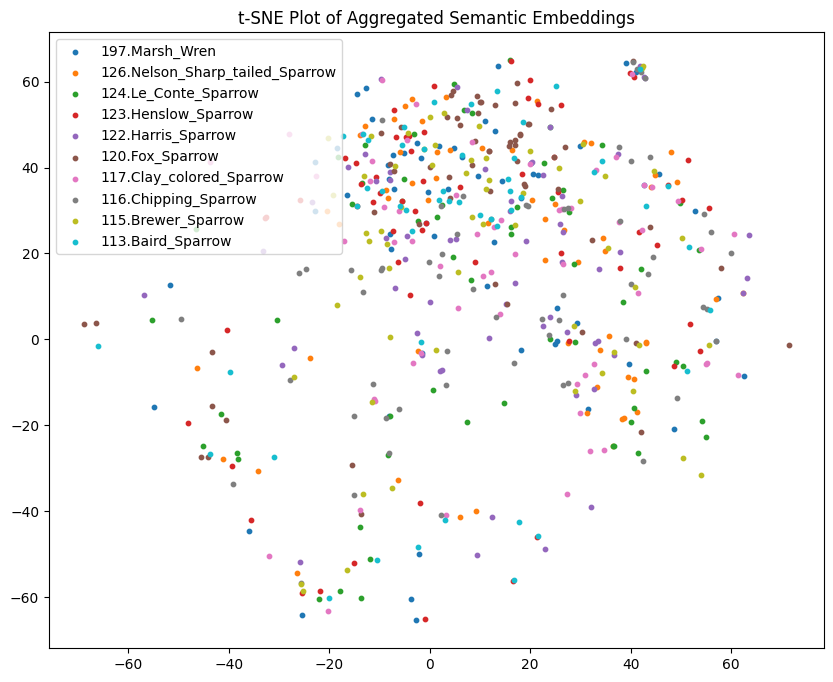

In [327]:
plt.figure(figsize=(10, 8))
for cls in top_classes:
    indices = top_class_indices[cls]
    cls_name = label_names[indices][0][0][0]
    plt.scatter(agg_tsne_embeddings[indices, 0], agg_tsne_embeddings[indices, 1], label=cls_name, s=10, alpha=1)

plt.title("t-SNE Plot of Aggregated Semantic Embeddings")
plt.legend()
plt.savefig("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/figures/agg_tsne.svg", format="svg", dpi=300)
plt.show()

In [328]:
# VISUALIZE AGG EMBEDDINGS WITH UMAP

In [329]:
umap = UMAP(n_components=2, random_state=537)
agg_umap_embeddings = umap.fit_transform(embeddings_agg)

/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


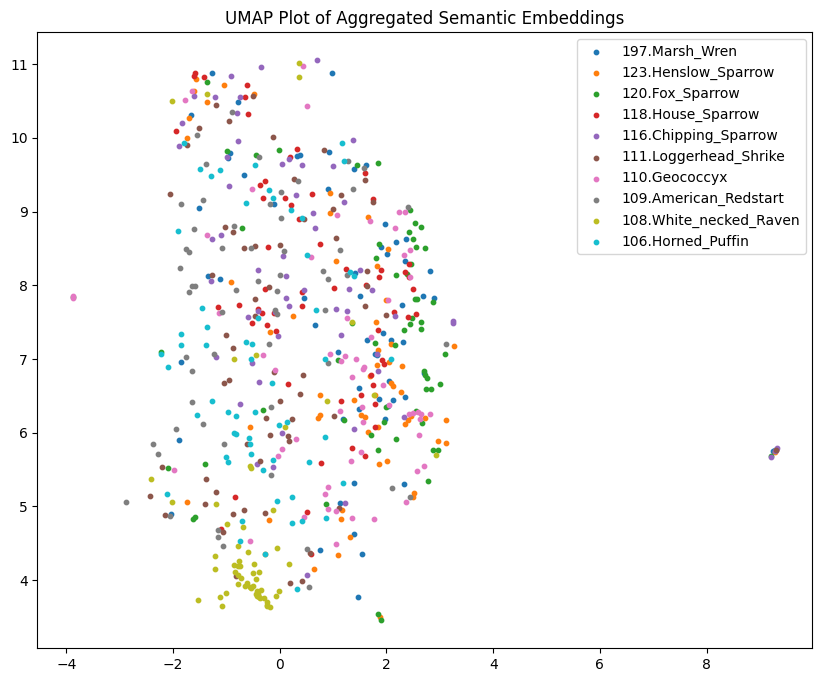

In [212]:
plt.figure(figsize=(10, 8))
for cls in top_classes:
    indices = top_class_indices[cls]
    cls_name = label_names[indices][0][0][0]
    plt.scatter(agg_umap_embeddings[indices, 0], agg_umap_embeddings[indices, 1], label=cls_name, s=10, alpha=1)

plt.title("UMAP Plot of Aggregated Semantic Embeddings")
plt.legend()
plt.savefig("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/figures/agg_umap.svg", format="svg", dpi=300)
plt.show()

In [213]:
# VISUALIZE AVG EMBEDDINGS WITH T-SNE

In [331]:
pca = PCA(n_components=50, random_state=537)
avg_pca_embeddings = pca.fit_transform(embeddings_avg)

In [332]:
tsne = TSNE(n_components=2, random_state=537)
avg_tsne_embeddings = tsne.fit_transform(embeddings_avg)

In [334]:
pairs = findClosestAndFurthestClasses(unique_labels, labels, avg_umap_embeddings, label_names)

Closest classes:  (np.uint8(21), np.uint8(24))
Furthest classes:  (np.uint8(7), np.uint8(75))

Closest classes:  (np.str_('028.Brown_Creeper'), np.str_('039.Least_Flycatcher'))
Furthest classes:  (np.str_('012.Yellow_headed_Blackbird'), np.str_('107.Common_Raven'))


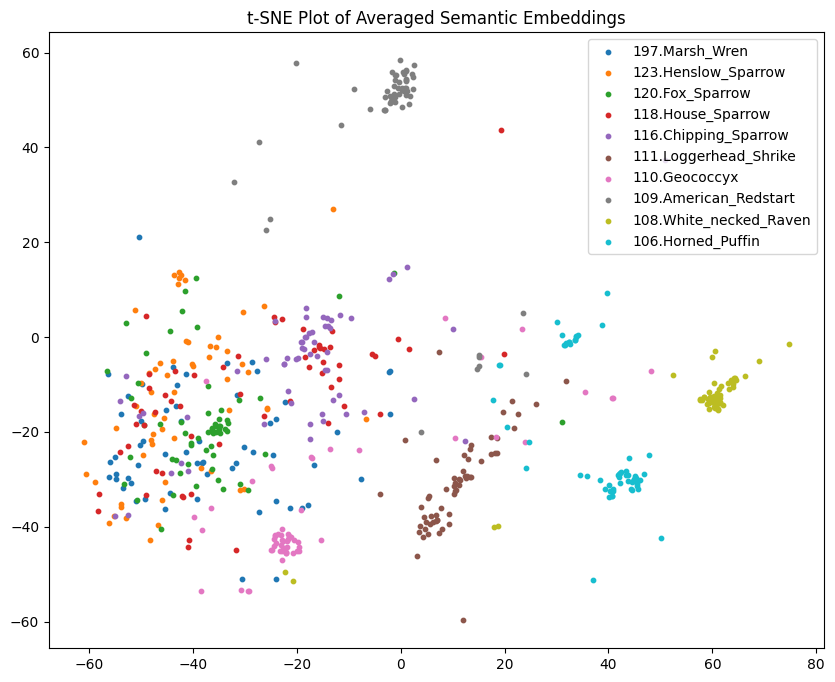

In [217]:
plt.figure(figsize=(10, 8))
for cls in top_classes:
    indices = top_class_indices[cls]
    cls_name = label_names[indices][0][0][0]
    plt.scatter(avg_tsne_embeddings[indices, 0], avg_tsne_embeddings[indices, 1], label=cls_name, s=10, alpha=1)

plt.title("t-SNE Plot of Averaged Semantic Embeddings")
plt.legend()
plt.savefig("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/figures/avg_tsne.svg", format="svg", dpi=300)
plt.show()

In [218]:
# VISUALIZE AGG EMBEDDINGS WITH UMAP

In [333]:
umap = UMAP(n_components=2, random_state=537)
avg_umap_embeddings = umap.fit_transform(embeddings_avg)

/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


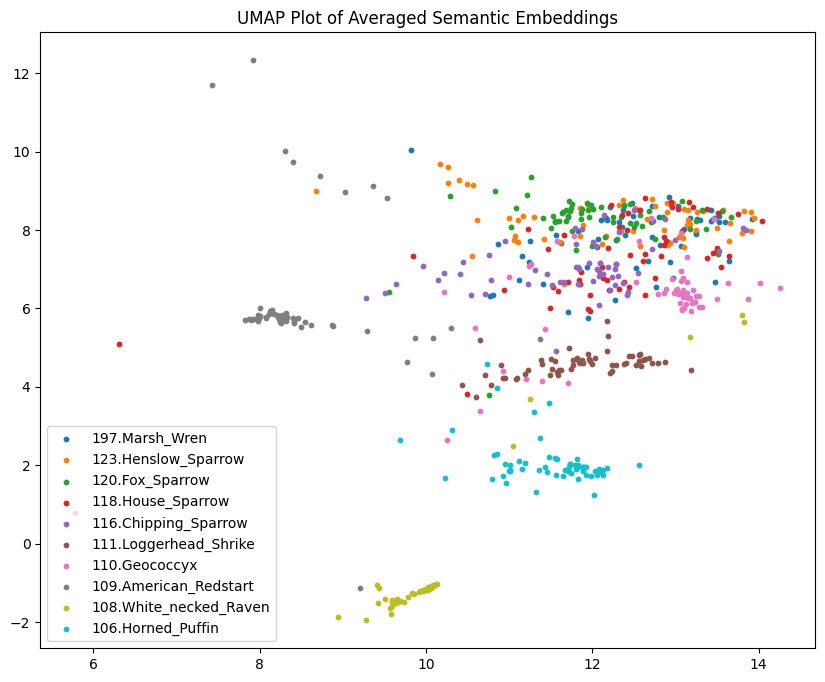

In [220]:
plt.figure(figsize=(10, 8))
for cls in top_classes:
    indices = top_class_indices[cls]
    cls_name = label_names[indices][0][0][0]
    plt.scatter(avg_umap_embeddings[indices, 0], avg_umap_embeddings[indices, 1], label=cls_name, s=10, alpha=1)

plt.title("UMAP Plot of Averaged Semantic Embeddings")
plt.legend()
plt.savefig("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/figures/avg_umap.svg", format="svg", dpi=300)
plt.show()

In [213]:
# VISUALIZE AVG CLASS EMBEDDINGS WITH T-SNE

In [221]:
pca = PCA(n_components=50, random_state=537)
class_avg_pca_embeddings = pca.fit_transform(class_attributes_avg)

In [259]:
tsne = TSNE(n_components=2, random_state=537)
class_avg_tsne_embeddings = tsne.fit_transform(class_attributes_avg)

In [260]:
def findClosestAndFurthestClasses2(unique_labels, labels, res101_tsne_features, label_names):
    average_tsne_features = {}
    for cls in unique_labels:
        average_tsne_features[cls] = res101_tsne_features[cls-1]
        
    cls_list = list(average_tsne_features.keys())
    average_feature_matrix = np.array([average_tsne_features[cls] for cls in cls_list])
    
    pairwise_distances = cdist(average_feature_matrix, average_feature_matrix, metric='euclidean')
    
    furthest_pair_indices = np.unravel_index(np.argmax(pairwise_distances), pairwise_distances.shape)
    furthest_classes = (cls_list[furthest_pair_indices[0]], cls_list[furthest_pair_indices[1]])
    
    np.fill_diagonal(pairwise_distances, np.inf)
    
    closest_pair_indices = np.unravel_index(np.argmin(pairwise_distances), pairwise_distances.shape)
    closest_classes = (cls_list[closest_pair_indices[0]], cls_list[closest_pair_indices[1]])
    
    closest_class_names = (label_names[np.where(labels == closest_classes[0])[0][0]][0][0], label_names[np.where(labels == closest_classes[1])[0][0]][0][0])
    furthest_class_names = (label_names[np.where(labels == furthest_classes[0])[0][0]][0][0], label_names[np.where(labels == furthest_classes[1])[0][0]][0][0])
    
    print("Closest classes: ", closest_classes)
    print("Furthest classes: ", furthest_classes)
    print()
    print("Closest classes: ", closest_class_names)
    print("Furthest classes: ", furthest_class_names)
    
    return closest_class_names, furthest_class_names

In [293]:
pairs = findClosestAndFurthestClasses2(unique_labels, labels, class_attributes_avg, label_names)

Closest classes:  (np.uint8(79), np.uint8(183))
Furthest classes:  (np.uint8(10), np.uint8(158))

Closest classes:  (np.str_('111.Loggerhead_Shrike'), np.str_('112.Great_Grey_Shrike'))
Furthest classes:  (np.str_('016.Painted_Bunting'), np.str_('029.American_Crow'))


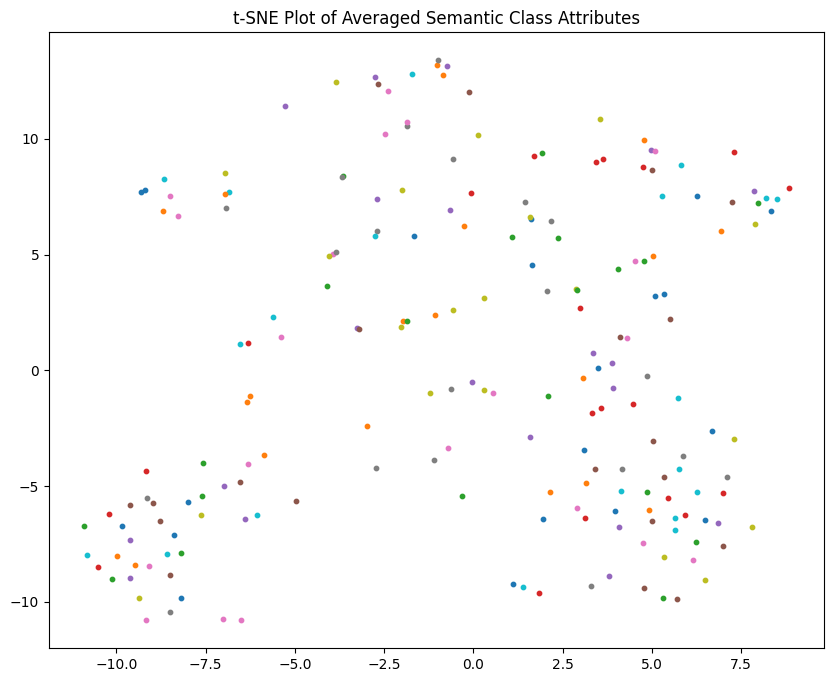

In [263]:
plt.figure(figsize=(10, 8))
for index in range(len(unique_labels)):
    cls_name = unique_names[index][0]
    plt.scatter(class_avg_tsne_embeddings[index, 0], class_avg_tsne_embeddings[index, 1], label=cls_name, s=10, alpha=1)

plt.title("t-SNE Plot of Averaged Semantic Class Attributes")
# plt.legend()
plt.savefig("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/figures/class_avg_tsne.svg", format="svg", dpi=300)
plt.show()

In [218]:
# VISUALIZE AVG CLASS EMBEDDINGS WITH UMAP

In [267]:
umap = UMAP(n_components=2, random_state=537)
class_avg_umap_embeddings = umap.fit_transform(class_attributes_avg)

/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


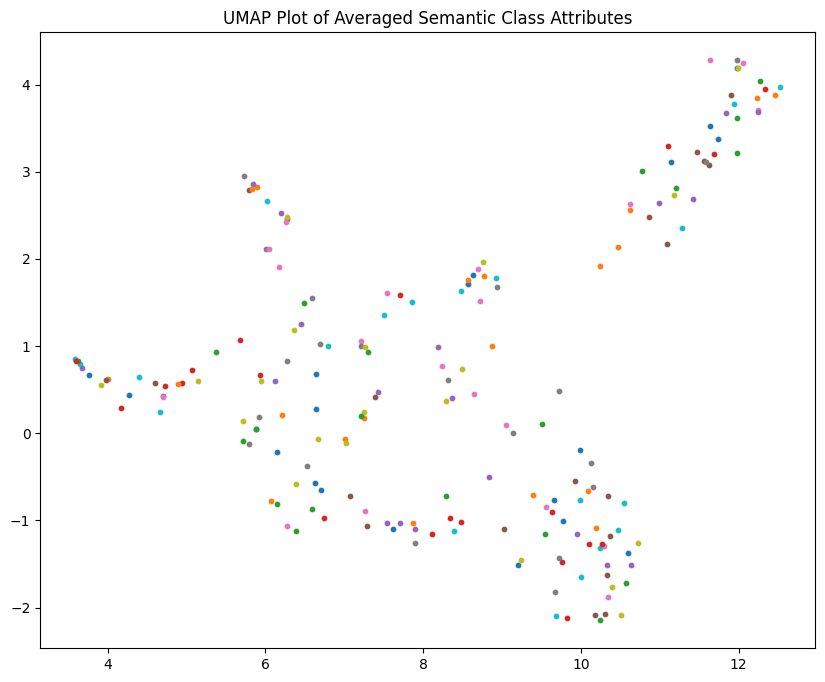

In [277]:
plt.figure(figsize=(10, 8))
for index in range(len(unique_labels)):
    cls_name = unique_names[index][0]
    plt.scatter(class_avg_umap_embeddings[index, 0], class_avg_umap_embeddings[index, 1], label=cls_name, s=10, alpha=1)

plt.title("UMAP Plot of Averaged Semantic Class Attributes")
# plt.legend()
plt.savefig("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/figures/class_avg_umap.svg", format="svg", dpi=300)
plt.show()

In [213]:
# VISUALIZE AGG CLASS EMBEDDINGS WITH T-SNE

In [269]:
pca = PCA(n_components=50, random_state=537)
class_agg_pca_embeddings = pca.fit_transform(class_attributes_agg)

In [273]:
tsne = TSNE(n_components=2, random_state=537)
class_agg_tsne_embeddings = tsne.fit_transform(class_attributes_agg)

In [292]:
pairs = findClosestAndFurthestClasses2(unique_labels, labels, class_attributes_agg, label_names)

Closest classes:  (np.uint8(146), np.uint8(200))
Furthest classes:  (np.uint8(10), np.uint8(158))

Closest classes:  (np.str_('195.Carolina_Wren'), np.str_('197.Marsh_Wren'))
Furthest classes:  (np.str_('016.Painted_Bunting'), np.str_('029.American_Crow'))


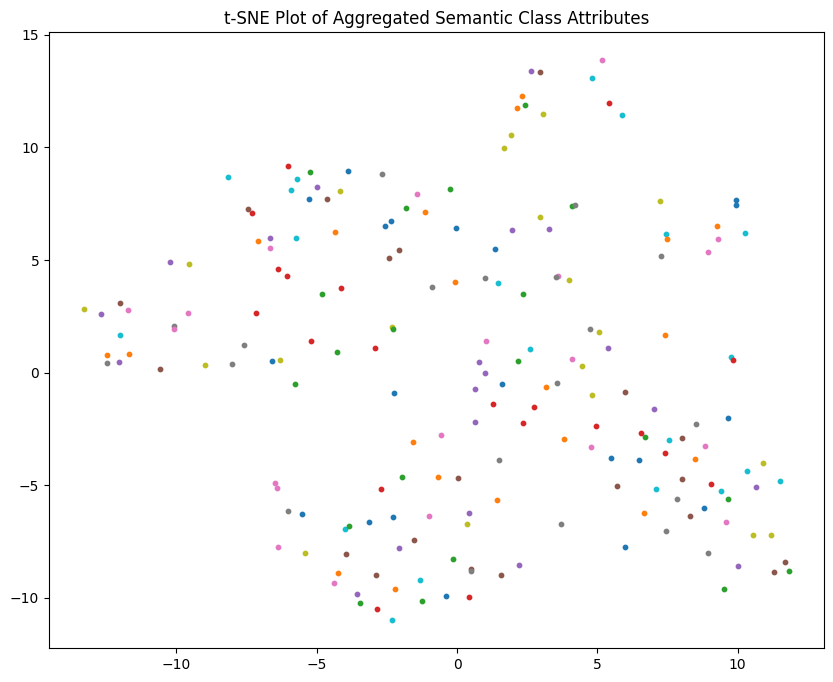

In [276]:
plt.figure(figsize=(10, 8))
for index in range(len(unique_labels)):
    cls_name = unique_names[index][0]
    plt.scatter(class_agg_tsne_embeddings[index, 0], class_agg_tsne_embeddings[index, 1], label=cls_name, s=10, alpha=1)

plt.title("t-SNE Plot of Aggregated Semantic Class Attributes")
# plt.legend()
plt.savefig("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/figures/class_agg_tsne.svg", format="svg", dpi=300)
plt.show()

In [218]:
# VISUALIZE AGG CLASS EMBEDDINGS WITH UMAP

In [278]:
umap = UMAP(n_components=2, random_state=537)
class_agg_umap_embeddings = umap.fit_transform(class_attributes_agg)

/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


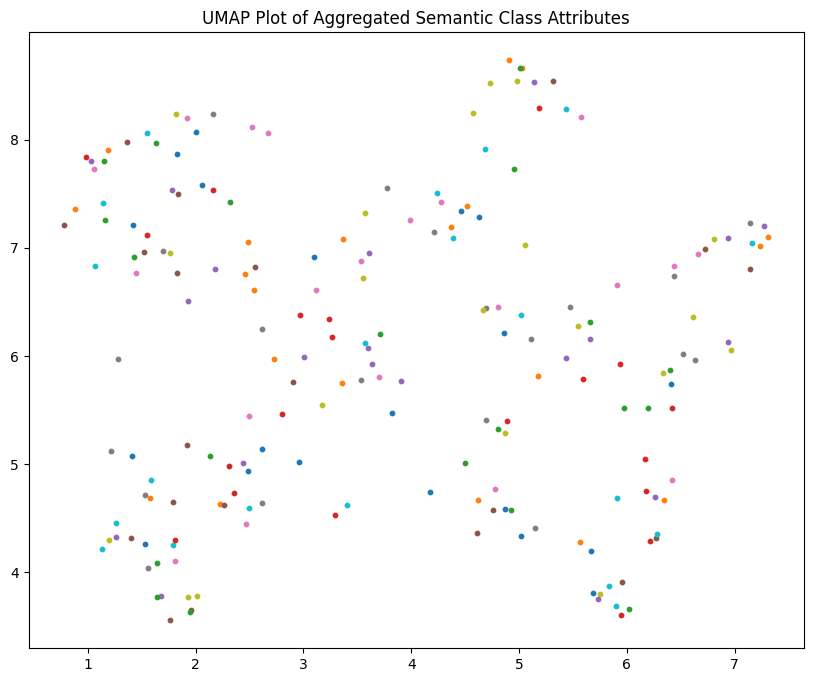

In [280]:
plt.figure(figsize=(10, 8))
for index in range(len(unique_labels)):
    cls_name = unique_names[index][0]
    plt.scatter(class_agg_umap_embeddings[index, 0], class_agg_umap_embeddings[index, 1], label=cls_name, s=10, alpha=1)

plt.title("UMAP Plot of Aggregated Semantic Class Attributes")
# plt.legend()
plt.savefig("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/figures/class_agg_umap.svg", format="svg", dpi=300)
plt.show()

In [213]:
# VISUALIZE ORIGINAL CLASS EMBEDDINGS WITH T-SNE

In [283]:
pca = PCA(n_components=50, random_state=537)
class_attributes_pca_embeddings = pca.fit_transform(class_attributes)

In [284]:
tsne = TSNE(n_components=2, random_state=537)
class_attributes_tsne_embeddings = tsne.fit_transform(class_attributes)

In [287]:
pairs = findClosestAndFurthestClasses2(unique_labels, labels, class_attributes, label_names)

Closest classes:  (np.uint8(22), np.uint8(158))
Furthest classes:  (np.uint8(16), np.uint8(180))

Closest classes:  (np.str_('030.Fish_Crow'), np.str_('029.American_Crow'))
Furthest classes:  (np.str_('022.Chuck_will_Widow'), np.str_('101.White_Pelican'))


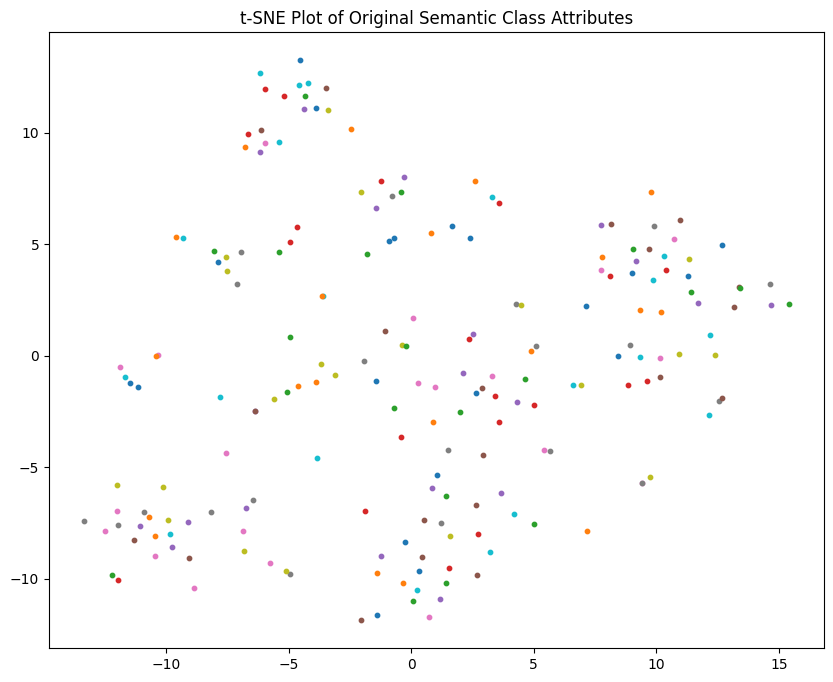

In [288]:
plt.figure(figsize=(10, 8))
for index in range(len(unique_labels)):
    cls_name = unique_names[index][0]
    plt.scatter(class_attributes_tsne_embeddings[index, 0], class_attributes_tsne_embeddings[index, 1], label=cls_name, s=10, alpha=1)

plt.title("t-SNE Plot of Original Semantic Class Attributes")
# plt.legend()
plt.savefig("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/figures/class_org_tsne.svg", format="svg", dpi=300)
plt.show()

In [218]:
# VISUALIZE AGG CLASS EMBEDDINGS WITH UMAP

In [290]:
umap = UMAP(n_components=2, random_state=537)
class_attributes_umap_embeddings = umap.fit_transform(class_attributes)

/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


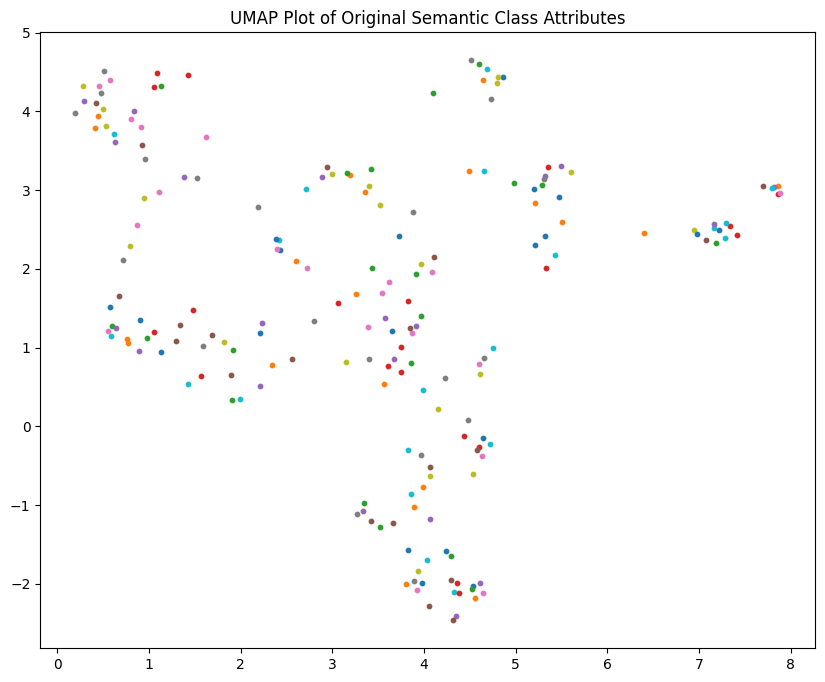

In [291]:
plt.figure(figsize=(10, 8))
for index in range(len(unique_labels)):
    cls_name = unique_names[index][0]
    plt.scatter(class_attributes_umap_embeddings[index, 0], class_attributes_umap_embeddings[index, 1], label=cls_name, s=10, alpha=1)

plt.title("UMAP Plot of Original Semantic Class Attributes")
# plt.legend()
plt.savefig("/Users/lkk/Documents/BOUN CMPE/CMPE 537-Computer Vision/Term Project/Code/Datasets/CUB_Paper/figures/class_org_umap.svg", format="svg", dpi=300)
plt.show()